In [5]:
from typing import TypedDict, List
import uuid
from langgraph.store.memory import InMemoryStore


In [3]:

class UserProfile(TypedDict):
    """User profile schema with typed fields."""
    user_name: str
    interests: List[str]

user_profile: UserProfile = {
    "user_name": "Angelo",
    "interests": ["anime", "technology", "games"]
}
user_profile

{'user_name': 'Angelo', 'interests': ['anime', 'technology', 'games']}

In [6]:
in_memory_store = InMemoryStore()
user_id = "1"
namespace_for_memory = (user_id, "memory")

key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

In [7]:
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': {'user_name': 'Angelo', 'interests': ['anime', 'technology', 'games']}, 'key': 'user_profile', 'namespace': ['1', 'memory'], 'created_at': '2025-01-01T19:37:16.650360+00:00', 'updated_at': '2025-01-01T19:37:16.650361+00:00', 'score': None}


In [8]:
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Angelo', 'interests': ['anime', 'technology', 'games']}

# Chatbot with profile schema

In [17]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

In [10]:
model = ChatOpenAI(model="gpt-4o", temperature=0)
model_with_structure = model.with_structured_output(UserProfile)

structured_output = model_with_structure.invoke([HumanMessage("My name is Angelo, I like to dance.")])
structured_output

{'user_name': 'Angelo', 'interests': ['dance']}

In [12]:
# system messages

MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history.
This will be saved for long-term memory. If there is an existing memory, simply update it.
Here is the existing memory (it may be empty): {memory}"""

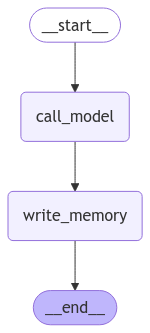

In [18]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response."""

    user_id = config["configurable"]["user_id"]

    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store."""

    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )

    else:
        formatted_memory = None

    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    key = "user_memory"
    store.put(namespace, key, new_memory)

builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()

graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [19]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

input_messages = [HumanMessage(content="Hi, my name is Angelo and I like to walk around churches and play the piano.")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Angelo and I like to walk around churches and play the piano.
================================== Ai Message ==================================

Hi Angelo! It's great to meet you. Walking around churches sounds like a peaceful activity, and playing the piano is such a wonderful skill to have. Do you have a favorite piece you like to play?


In [20]:
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Angelo',
 'interests': ['walking around churches', 'playing the piano']}

# Point of failure

In [22]:
from typing import List, Optional
from pydantic import ValidationError

In [23]:
class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

In [24]:
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
                                <convo>
                                {conversation}
                                </convo>""")
except ValidationError as e:
    print(e)

1 validation error for TelegramAndTrustFallPreferences
pertinent_user_preferences.communication_preferences.semaphore
  Input should be a valid dictionary or instance of Semaphore [type=model_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.10/v/model_type


# Trustcalls

In [25]:
from trustcall import create_extractor

In [26]:
conversation = [HumanMessage(content="Hi, I'm Angelo."),
                AIMessage(content="Nice to meet you, Angelo."),
                HumanMessage(content="I really like to watch Thomas the Tank Engine.")]

class UserProfile(BaseModel):
    """User profiel schema with typed fields"""
    user_name: str = Field(description="tThe user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")

trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

system_msg = "Extract the user profile from the following conversation"

result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})


In [27]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_oJS4o91IKDDxbu0SEIpi9ZaS)
 Call ID: call_oJS4o91IKDDxbu0SEIpi9ZaS
  Args:
    user_name: Angelo
    interests: ['Thomas the Tank Engine']


In [28]:
schema = result["responses"]
schema

[UserProfile(user_name='Angelo', interests=['Thomas the Tank Engine'])]

In [30]:
schema[0].model_dump()

{'user_name': 'Angelo', 'interests': ['Thomas the Tank Engine']}

In [31]:
result["response_metadata"]

[{'id': 'call_oJS4o91IKDDxbu0SEIpi9ZaS'}]

In [32]:
updated_conversation = [HumanMessage(content="Hi, I'm Angelo."),
                AIMessage(content="Nice to meet you, Angelo."),
                HumanMessage(content="I really like to watch Thomas the Tank Engine."),
                AIMessage(content="Thomas the Tank Engine is a really good show! Who is your favorite character?"),
                HumanMessage(content="I really like Thomas.")]

system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation},
                                    {"existing": {"UserProfile": schema[0].model_dump()}})

In [33]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_UXd6GgMqHCiXrmy8NOas4dYV)
 Call ID: call_UXd6GgMqHCiXrmy8NOas4dYV
  Args:
    user_name: Angelo
    interests: ['Thomas the Tank Engine']


In [34]:
result["response_metadata"]

[{'id': 'call_UXd6GgMqHCiXrmy8NOas4dYV'}]

In [35]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Angelo', 'interests': ['Thomas the Tank Engine']}

In [36]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# Extract the preferences
result["responses"][0]

TelegramAndTrustFallPreferences(pertinent_user_preferences=UserPreferences(communication_preferences=CommunicationPreferences(telegram=TelegramPreferences(preferred_encoding=[OutputFormat(preference='Morse', sentence_preference_revealed='Morse code or standard encoding?')], favorite_telegram_operators=None, preferred_telegram_paper=[OutputFormat(preference='Daredevil', sentence_preference_revealed='Shall I use our "Daredevil" paper for this daring message?')]), morse_code=MorseCode(preferred_key_type=[OutputFormat(preference='straight key', sentence_preference_revealed='I love using a straight key.')], favorite_morse_abbreviations=None), semaphore=Semaphore(preferred_flag_color=None, semaphore_skill_level=None)), trust_fall_preferences=TrustFallPreferences(preferred_fall_height=[OutputFormat(preference='higher', sentence_preference_revealed="I'm ready for a higher fall")], trust_level=None, preferred_catching_technique=[OutputFormat(preference='diamond formation', sentence_preference_r

# Chatbot with profile schema updating

In [37]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

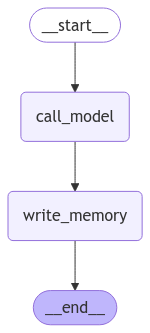

In [38]:
from zmq import Message


model = ChatOpenAI(model="gpt-4o", temperature=0)

class UserProfile(BaseModel):
    """Profile of a user"""
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state:MessagesState, config: RunnableConfig, store:BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response."""
    user_id = config["configurable"]["user_id"]

    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state:MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store"""

    user_id = config["configurable"]["user_id"]
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None

    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"], "existing": existing_profile})

    updated_profile = result["responses"][0].model_dump()

    key = "user_memory"
    store.put(namespace, key, updated_profile)

builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()

graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

input_messages = [HumanMessage(content="Hi, my name is Angelo")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()